In [ ]:
from google.colab import drive, files
from __future__ import absolute_import, unicode_literals, print_function
import matplotlib.pyplot as plt 
import pickle 
import cv2 
import numpy as np 
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import os 

Loads the pickle that stores the pictures of dogs

In [ ]:
drive.mount('/content/gdrive')
data = pickle.load(open('/content/gdrive/My Drive/Data/Dogs and Cats/denoise_training.pickle', 'rb'))

Mounted at /content/gdrive


In [ ]:
# matplotlib displays color in BGR format, we are converting that to RGB
def plot_rgb_img(img):
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

Load a picture

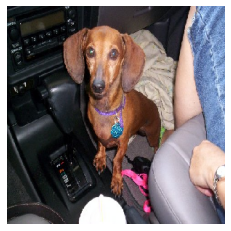

In [ ]:
plot_rgb_img(data[21])

Here are some ways to add noise to images

In [ ]:
def add_gaussian_blur(data):
  dst = cv2.GaussianBlur(data, (35, 35), cv2.BORDER_DEFAULT)
  return dst

In [ ]:
# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise

In [ ]:
# adds salt and pepper noise 
def add_salt_pepper_noise(data, p=0.05):
  rows, columns, channels = data.shape
  output = np.zeros(data.shape, np.uint8)
  for i in range(rows):
    for j in range(columns):
      r = np.random.random()
      if r < p/2:
        output[i][j] = [0, 0, 0]
      elif r > p/2 and r <= p:
        output[i][j] = [255, 255, 255]
      else:
        output[i][j] = data[i][j]
  return output

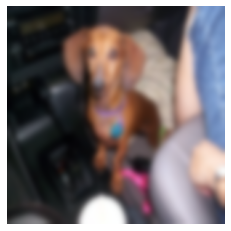

In [ ]:
plot_rgb_img(add_gaussian_blur(data[21]))

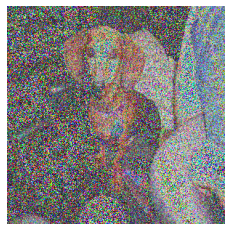

In [ ]:
plot_rgb_img(add_gaussian_noise(data[21]))

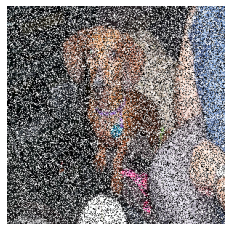

In [ ]:
plot_rgb_img(add_salt_pepper_noise(data[21], p=0.5))

Apply it to an entire dataset rather than one image 

In [ ]:
def add_gaussian_to_dataset(data):
  count = 0
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_noise(data[count]))
    count+=1
  return np.array(output_data)

In [ ]:
def add_gaussian_blur_to_dataset(data):
  count = 0 
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_blur(data[count]))
    count+=1
  return np.array(output_data)

I am using a smaller training set to reserve memory, use more pictures if you have a lot of RAM. 

In [ ]:
train_data = data[:2500]
test_data = data[3000:3500]
# uncomment this for denoiser 
# gaussian_train_data = add_gaussian_to_dataset(train_data)
# gaussian_test_data = add_gaussian_to_dataset(test_data)

In [ ]:
gaussian_train_data = add_gaussian_to_dataset(train_data)
gaussian_test_data = add_gaussian_to_dataset(test_data)

Scale the data between 0 and 1

In [ ]:
train_data = train_data / 255.0
test_data = test_data / 255.0
# reduce images
gaussian_train_data = gaussian_train_data / 255.0 
gaussian_test_data = gaussian_test_data / 255.0 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Construct the autoencoder model

In [ ]:
def create_model():
  x = Input(shape=(300, 300, 3)) 

  # Encoder
  e_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  pool1 = MaxPooling2D((2, 2), padding='same')(e_conv1)
  batchnorm_1 = BatchNormalization()(pool1)
  e_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(batchnorm_1)
  pool2 = MaxPooling2D((2, 2), padding='same')(e_conv2)
  batchnorm_2 = BatchNormalization()(pool2)
  e_conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(batchnorm_2)
  h = MaxPooling2D((2, 2), padding='same')(e_conv3)


  # Decoder
  d_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
  up1 = UpSampling2D((2, 2))(d_conv1)
  d_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
  up2 = UpSampling2D((2, 2))(d_conv2)
  d_conv3 = Conv2D(16, (3, 3), activation='relu')(up2)
  up3 = UpSampling2D((2, 2))(d_conv3)
  r = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up3)

  model = Model(x, r)
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
gaussian_auto_encoder = create_model()
gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)
gaussian_history = gaussian_auto_encoder.fit(gaussian_train_data, train_data, epochs=50, batch_size=32, callbacks=[gaussian_early_stop])

Epoch 1/50
79/79 [==============================] - 40s 106ms/step - loss: 0.0256
Epoch 2/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0126
Epoch 3/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0114
Epoch 4/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0100
Epoch 5/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0100
Epoch 6/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0111
Epoch 7/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0090
Epoch 8/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0095
Epoch 9/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0084
Epoch 10/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0096
Epoch 11/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0090
Epoch 12/50
79/79 [==============================] - 8s 102ms/step - loss: 0.0086
Epoch 13/50
79/79 [=====

Plot the training loss

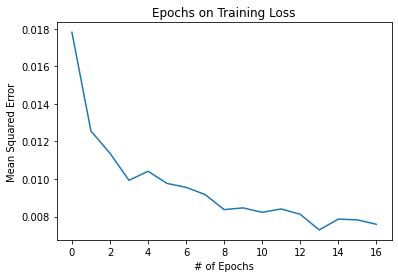

In [ ]:
plt.plot(gaussian_history.epoch, gaussian_history.history['loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
# gaussian_auto_encoder.save('gaussian_blur.model')
# files.download('gaussian_blur.model')

Evaluate the model on the test set

In [ ]:
result = gaussian_auto_encoder.predict(gaussian_test_data)
gaussian_auto_encoder.evaluate(test_data, gaussian_test_data)

16/16 [==============================] - 1s 44ms/step - loss: 0.0912


0.09123189002275467

Compare the images

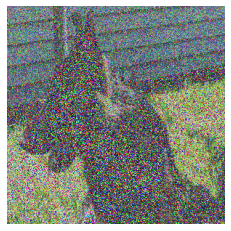

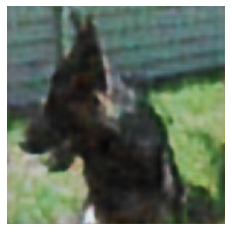

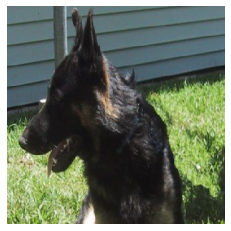

In [ ]:
plot_rgb_img(add_gaussian_noise(data[3021]))
plot_rgb_img(result[21])
plot_rgb_img(data[3021])